# MOFA training different models

We train MOFA on TCGA-BRCA with:
- different K per view (K1 for mRNA, K2 for DNAm, K3 for RPPA),
- feature selection:
  - most variable features per view,
  - ANOVA F-score vs PAM50 per view,
- patient sets:
  - all patients (union of samples across views),
  - intersection patients (present in all three views).

For each configuration we:
1. select K1/K2/K3 features per view,
2. build a MuData object for the chosen patient set,
3. train MOFA with a fixed number of factors,
4. save the model to `../models/mofa/exports_500/mofa_{method}_Kperview_{patients}.hdf5`.


Then we run logerg for different factor configurations.

In the end we check for the most 'informative' features that were forming MOFA factors.

## MOFA training

### Imports and configuration

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import scanpy as sc
import muon as mu

import matplotlib.pyplot as plt
import seaborn as sns

import mofax as mofa 
from utils.omic_helpers import *


DATA_DIR = "../data/TCGA-BRCA/"
EXPORT_DIR = "../models/mofa/exports_500"
os.makedirs(EXPORT_DIR, exist_ok=True)

VIEWS = ["mRNA", "DNAm", "RPPA"]

# K1/K2/K3: number of features per view
N_KEEP_PER_VIEW = {
    "mRNA": 500, # K1
    "DNAm": 500, # K2
    "RPPA": 464, # K3 ( keep all proteins)
}

# number of MOFA factors
MOFA_N_FACTORS = 15

# view that carries PAM50 labels for ANOVA, doesnt really matter, they are all the same
LABEL_VIEW = "mRNA"

C:\Users\Petar\anaconda3\Lib\site-packages\muon\_core\preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


### Load data and compute patient sets

In [2]:
data = {}
for omic in VIEWS:
    with open(os.path.join(DATA_DIR, f"{omic}.pkl"), "rb") as f:
        data[omic] = pickle.load(f)

for v in VIEWS:
    X = data[v]["expr"]
    print(f"{v}: {X.shape[0]} samples × {X.shape[1]} features")

# patient sets
idx_per_view = {v: set(data[v]["expr"].index) for v in VIEWS}
patients_intersection = sorted(set.intersection(*idx_per_view.values()))
patients_all = sorted(set.union(*idx_per_view.values()))

print(f"Intersection patients: {len(patients_intersection)}")
print(f"All patients (union):  {len(patients_all)}")

C:\Users\Petar\AppData\Local\Temp\ipykernel_12368\2528944166.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)
C:\Users\Petar\AppData\Local\Temp\ipykernel_12368\2528944166.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access

mRNA: 500 samples × 29995 features
DNAm: 500 samples × 100000 features
RPPA: 500 samples × 464 features
Intersection patients: 401
All patients (union):  658


C:\Users\Petar\AppData\Local\Temp\ipykernel_12368\2528944166.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)


### MOFA helper: build MuData from filtered views

In [3]:
VIEW_TO_MODKEY = {"mRNA": "rna", "DNAm": "dna", "RPPA": "rppa"}


def build_mdata_from_filtered_views(
    filtered_data: dict,
    full_data: dict,
    views: list[str],
    patient_mode: str = "all",
) -> mu.MuData:
    """
    Construct a MuData object from filtered views.

    patient_mode:
        "all"          -> union of sample IDs across views
        "intersection" -> only samples present in all views
    """
    expr_list = [filtered_data[v]["expr"] for v in views]

    if patient_mode == "all":
        idx = expr_list[0].index
        for X in expr_list[1:]:
            idx = idx.union(X.index)
    elif patient_mode == "intersection":
        idx = expr_list[0].index
        for X in expr_list[1:]:
            idx = idx.intersection(X.index)
    else:
        raise ValueError("patient_mode must be 'all' or 'intersection'")

    idx = idx.sort_values()

    # modalities
    mods = {}
    for v in views:
        df = filtered_data[v]["expr"].reindex(idx)
        mod_key = VIEW_TO_MODKEY.get(v, v.lower())
        mods[mod_key] = sc.AnnData(df)

    mdata = mu.MuData(mods)

    # metadata in obs: concat meta from all views (reindexed)
    meta_frames = []
    for v in views:
        meta = full_data[v].get("meta", None)
        if meta is not None:
            meta_frames.append(meta.reindex(idx))

    if meta_frames:
        meta = pd.concat(meta_frames, axis=1)
        meta = meta.loc[:, ~meta.columns.duplicated()]
        mdata.obs = meta

    return mdata


### Configuration of grid: feature selection & patient modes

In [4]:
SELECTION_METHODS = ["var", "anova"]        # feature ranking
PATIENT_MODES = ["all", "intersection"]     # patient sets

### Main loop: train MOFA for all configurations

In [6]:
for sel in SELECTION_METHODS:
    # ------------------------------------------------------
    # 1) Select K1/K2/K3 features per view
    # ------------------------------------------------------
    if sel == "var":
        print("\n### Feature selection: most variable per view")
        filtered_data, feat_idx = select_top_variable_features_per_view(
            data,
            n_keep_per_view=N_KEEP_PER_VIEW,
            views=VIEWS,
            use="var",    # or "mad" if you want
        )
        method_tag = "var"

    elif sel == "anova":
        print("\n### Feature selection: ANOVA vs PAM50 per view")
        filtered_data, feat_idx = select_top_anova_features_per_view(
            data,
            n_keep_per_view=N_KEEP_PER_VIEW,
            views=VIEWS,
            label_view=LABEL_VIEW,
        )
        method_tag = "anova"

    else:
        raise ValueError(f"Unknown selection method: {sel}")

    # ------------------------------------------------------
    # 2) For this feature set, train MOFA for both patient sets
    # ------------------------------------------------------
    for patient_mode in PATIENT_MODES:
        tag = f"{method_tag}_Kperview_{patient_mode}"
        outfile = os.path.join(EXPORT_DIR, f"mofa_{tag}.hdf5")

        print(f"\n=== Training MOFA: method={method_tag}, patients={patient_mode} ===")

        mdata = build_mdata_from_filtered_views(
            filtered_data=filtered_data,
            full_data=data,
            views=VIEWS,
            patient_mode=patient_mode,
        )

        print("  - Samples in mdata:", mdata.n_obs)
        for mod_key in mdata.mod:
            print(f"    {mod_key}: {mdata[mod_key].X.shape}")

        mu.tl.mofa(
            mdata,
            use_obs="union",          # same as in your existing notebook
            n_factors=MOFA_N_FACTORS,
            convergence_mode="medium",
            outfile=outfile,
        )

        print(f"  --> saved MOFA model to: {outfile}")



### Feature selection: most variable per view
mRNA: kept 500 / 29995 features (most variable, var)
DNAm: kept 500 / 100000 features (most variable, var)
RPPA: kept 464 / 464 features (most variable, var)

=== Training MOFA: method=var, patients=all ===
  - Samples in mdata: 658
    rna: (658, 500)
    dna: (658, 500)
    rppa: (658, 464)

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=

C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian
- View 1 (dna): gaussian
- View 2 (rppa): gaussian




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in exports_500\mofa_var_Kperview_all.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].
  --> saved MOFA model to: exports_500\mofa_var_Kperview_all.hdf5

=== Training MOFA: method=var, patients=intersection ===
  - Samples in mdata: 401
    rna: (401, 500)
    dna: (401, 500)
    rppa: (401, 464)

        #########################################################
        ###           __  __  ____  ______           

## Logistic regression

### Prepare PAM50_any labels

In [9]:
pam_rna_full  = get_pam50(data,"mRNA")
pam_meth_full = get_pam50(data,"DNAm")
pam_prot_full = get_pam50(data,"RPPA")

pam_any = pam_rna_full.copy()
pam_any = pam_any.combine_first(pam_meth_full)
pam_any = pam_any.combine_first(pam_prot_full)
pam_any.name = "PAM50_any"

pam_any.value_counts(dropna=False)

PAM50_any
LumA     352
LumB     138
Basal    119
Her2      49
Name: count, dtype: int64

### Helper to run logistic regression on one MOFA embedding

### Four MOFA model files

In [10]:
MODEL_FILES = {
    "var_all":          os.path.join(EXPORT_DIR, "mofa_var_Kperview_all.hdf5"),
    "var_intersection": os.path.join(EXPORT_DIR, "mofa_var_Kperview_intersection.hdf5"),
    "anova_all":        os.path.join(EXPORT_DIR, "mofa_anova_Kperview_all.hdf5"),
    "anova_intersection": os.path.join(EXPORT_DIR, "mofa_anova_Kperview_intersection.hdf5"),
}

MODEL_FILES

{'var_all': 'exports_500\\mofa_var_Kperview_all.hdf5',
 'var_intersection': 'exports_500\\mofa_var_Kperview_intersection.hdf5',
 'anova_all': 'exports_500\\mofa_anova_Kperview_all.hdf5',
 'anova_intersection': 'exports_500\\mofa_anova_Kperview_intersection.hdf5'}

### Loop: load factors from each model, run logreg, collect metrics


Loading MOFA model: var_all from exports_500\mofa_var_Kperview_all.hdf5
Factors shape: (658, 15)


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


VAR ALL: best params {'clf__C': 0.1, 'clf__penalty': 'l2'}
CV balanced accuracy: 0.819 ± 0.018
Test balanced accuracy: 0.796
Test accuracy:        0.795
Test ROC-AUC (OvR):   0.942

Classification report:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        24
        Her2       0.89      0.80      0.84        10
        LumA       0.83      0.81      0.82        70
        LumB       0.53      0.57      0.55        28

    accuracy                           0.80       132
   macro avg       0.81      0.80      0.80       132
weighted avg       0.80      0.80      0.80       132



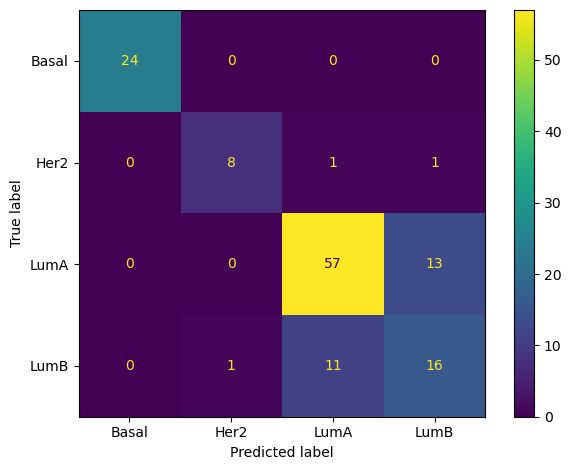


Loading MOFA model: var_intersection from exports_500\mofa_var_Kperview_intersection.hdf5
Factors shape: (401, 15)


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


VAR INTERSECTION: best params {'clf__C': 1.0, 'clf__penalty': 'l1'}
CV balanced accuracy: 0.836 ± 0.057
Test balanced accuracy: 0.781
Test accuracy:        0.815
Test ROC-AUC (OvR):   0.911

Classification report:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        12
        Her2       1.00      0.67      0.80         6
        LumA       0.85      0.87      0.86        46
        LumB       0.56      0.59      0.57        17

    accuracy                           0.81        81
   macro avg       0.85      0.78      0.81        81
weighted avg       0.82      0.81      0.82        81



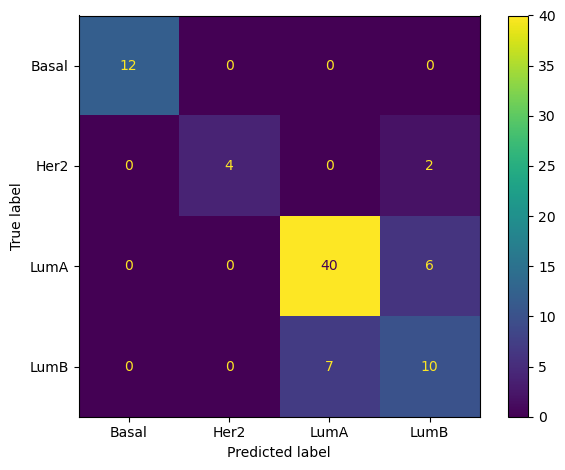


Loading MOFA model: anova_all from exports_500\mofa_anova_Kperview_all.hdf5
Factors shape: (658, 15)


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


ANOVA ALL: best params {'clf__C': 0.1, 'clf__penalty': 'l2'}
CV balanced accuracy: 0.827 ± 0.030
Test balanced accuracy: 0.874
Test accuracy:        0.864
Test ROC-AUC (OvR):   0.950

Classification report:
              precision    recall  f1-score   support

       Basal       0.96      0.92      0.94        24
        Her2       0.90      0.90      0.90        10
        LumA       0.90      0.86      0.88        70
        LumB       0.72      0.82      0.77        28

    accuracy                           0.86       132
   macro avg       0.87      0.87      0.87       132
weighted avg       0.87      0.86      0.87       132



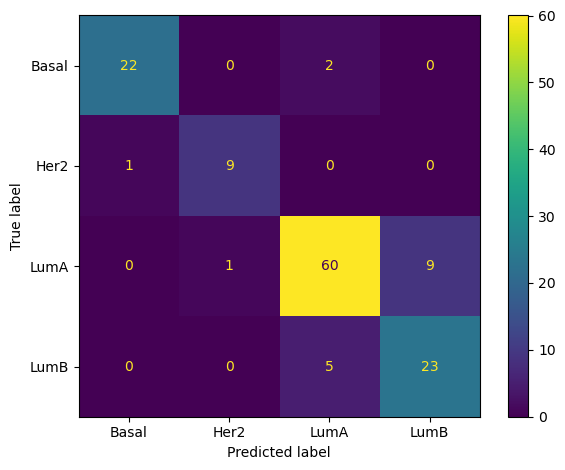


Loading MOFA model: anova_intersection from exports_500\mofa_anova_Kperview_intersection.hdf5
Factors shape: (401, 15)


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


ANOVA INTERSECTION: best params {'clf__C': 1.0, 'clf__penalty': 'l1'}
CV balanced accuracy: 0.878 ± 0.064
Test balanced accuracy: 0.803
Test accuracy:        0.802
Test ROC-AUC (OvR):   0.917

Classification report:
              precision    recall  f1-score   support

       Basal       0.92      1.00      0.96        12
        Her2       0.71      0.83      0.77         6
        LumA       0.85      0.85      0.85        46
        LumB       0.60      0.53      0.56        17

    accuracy                           0.80        81
   macro avg       0.77      0.80      0.78        81
weighted avg       0.80      0.80      0.80        81



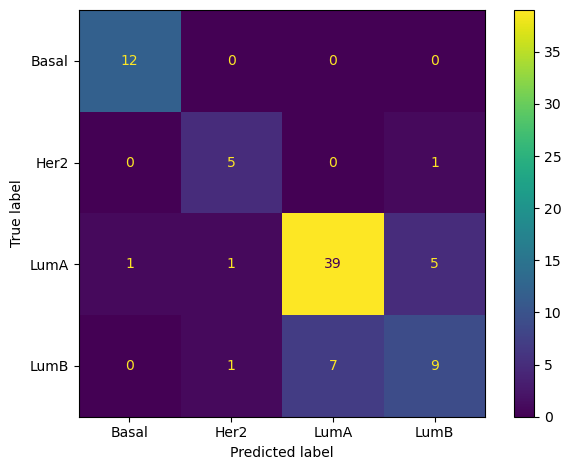

,title,best_params,mean_cv_bal_acc,std_cv_bal_acc,test_bal_acc,test_acc,test_roc_auc_ovr
0,VAR ALL,"{'clf__C': 0.1, 'clf__penalty': 'l2'}",0.819264,0.017516,0.796429,0.795455,0.941860
1,VAR INTERSECTION,"{'clf__C': 1.0, 'clf__penalty': 'l1'}",0.836473,0.057358,0.781117,0.814815,0.910807
2,ANOVA ALL,"{'clf__C': 0.1, 'clf__penalty': 'l2'}",0.826870,0.029957,0.873810,0.863636,0.950070
3,ANOVA INTERSECTION,"{'clf__C': 1.0, 'clf__penalty': 'l1'}",0.878166,0.064123,0.802643,0.802469,0.917288


In [11]:
results = []

for key, path in MODEL_FILES.items():
    print("\n" + "=" * 80)
    print(f"Loading MOFA model: {key} from {path}")
    model = mofa.mofa_model(path)

    # factors as DataFrame
    # index: sample IDs, columns: Factor1,...,FactorK
    factors_df = model.get_factors(df=True)  # docs: df=True -> DataFrame

    print("Factors shape:", factors_df.shape)

    res = run_logreg_on_factors(
        X_factors=factors_df,
        labels_any=pam_any,
        title=key.replace("_", " ").upper(),
        verbose=True,
    )
    results.append(res)

# Summary table
results_df = pd.DataFrame(results)
results_df


## Interpretability - which features drive the factors

### Overall - looking at maximum over factors

In [7]:
# Feature selection: most variable per view (K per view)
filtered_data_var, feat_idx_var = select_top_variable_features_per_view(
    data,
    n_keep_per_view=N_KEEP_PER_VIEW, 
    views=VIEWS,                   
    use="var",
)

# Build MuData for patient_mode="all"

mdata_var_all = build_mdata_from_filtered_views(
    filtered_data=filtered_data_var,
    full_data=data,
    views=VIEWS,
    patient_mode="all",  
)

print("mdata_var_all:")
print("  n_obs:", mdata_var_all.n_obs)
for mod_key in mdata_var_all.mod:
    print(f"  {mod_key}: {mdata_var_all[mod_key].X.shape}")

# Load the corresponding MOFA model
tag = "var_Kperview_intersection"
model_path = os.path.join(EXPORT_DIR, f"mofa_{tag}.hdf5")
print("\nLoading MOFA model from:", model_path)

model_var_all = mofa.mofa_model(model_path)


# Compute top 30 features globally (across all views)
modality_keys = list(mdata_var_all.mod.keys())  # usually ['rna', 'dna', 'rppa']
print("\nModalities in mdata:", modality_keys)

top30_global_var_all = top_mofa_features_global(
    model=model_var_all,
    mdata=mdata_var_all,
    modalities=modality_keys,
    top_n=30,
    agg="max",   # or "l2"
)

top30_global_var_all


mRNA: kept 500 / 29995 features (most variable, var)
DNAm: kept 500 / 100000 features (most variable, var)
RPPA: kept 464 / 464 features (most variable, var)
mdata_var_all:
  n_obs: 658
  rna: (658, 500)
  dna: (658, 500)
  rppa: (658, 464)

Loading MOFA model from: exports_500\mofa_var_Kperview_intersection.hdf5

Modalities in mdata: ['rna', 'dna', 'rppa']


C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


,modality,feature,score
0,rna,ENSG00000153002.12,1.130651
1,rna,ENSG00000120251.21,1.034453
2,rna,ENSG00000173467.9,0.994721
3,rna,ENSG00000172551.11,0.979640
4,rna,ENSG00000160182.3,0.969279
5,rna,ENSG00000159763.4,0.899906
6,rna,ENSG00000180730.5,0.881496
7,rna,ENSG00000256612.7,0.858985
8,rna,ENSG00000255974.8,0.846296
9,rna,ENSG00000106541.12,0.837553


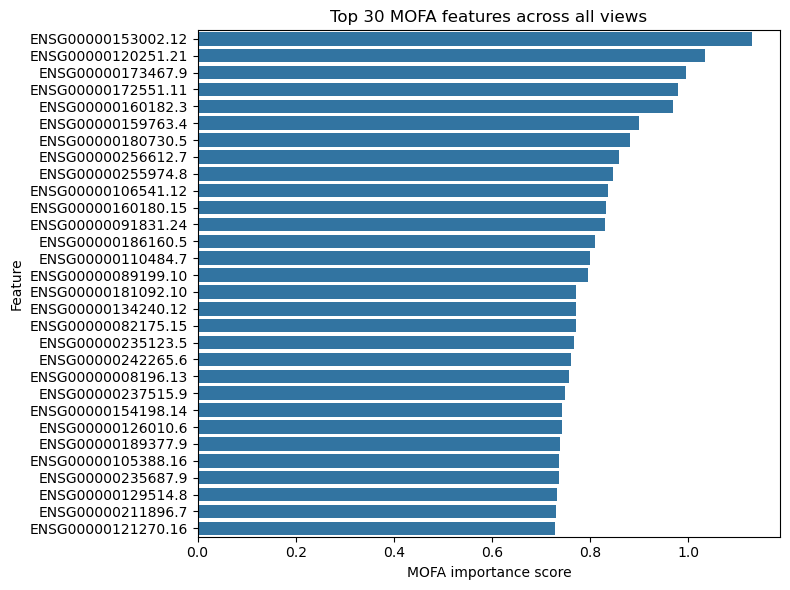

In [14]:
df = top30_global_var_all.copy()
df_sorted = df.sort_values("score", ascending=False)  # biggest first

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_sorted,
    x="score",
    y="feature",
    hue="modality",
    dodge=False,
    ax=ax,
)

ax.set_xlabel("MOFA importance score")
ax.set_ylabel("Feature")
ax.set_title("Top 30 MOFA features across all views")
#ax.legend(title="Modality", bbox_to_anchor=(1.05, 1), loc="upper left")
if ax.get_legend() is not None:
    ax.get_legend().remove()

fig.tight_layout()
fig.savefig("top20_mofa_features_global.pdf", dpi=300, bbox_inches="tight")
plt.show()


Modalities: ['rna', 'dna', 'rppa']

=== Top 20 features in modality 'rna' ===


,feature,score
0,ENSG00000153002.12,1.130651
1,ENSG00000120251.21,1.034453
2,ENSG00000173467.9,0.994721
3,ENSG00000172551.11,0.979640
4,ENSG00000160182.3,0.969279
5,ENSG00000159763.4,0.899906
6,ENSG00000180730.5,0.881496
7,ENSG00000256612.7,0.858985
8,ENSG00000255974.8,0.846296
9,ENSG00000106541.12,0.837553


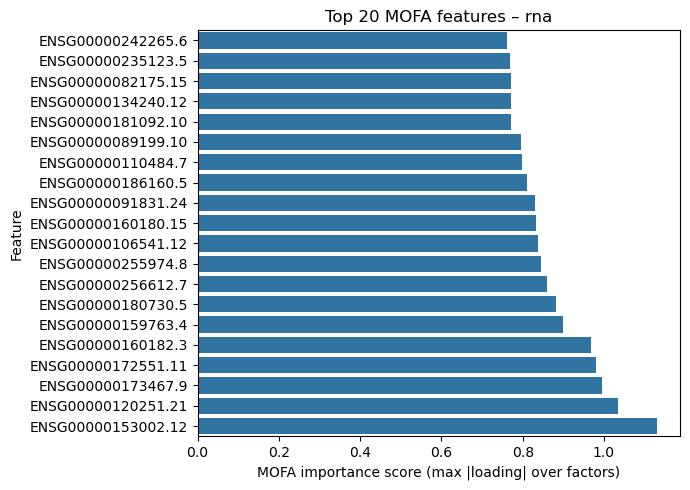


=== Top 20 features in modality 'dna' ===


,feature,score
0,cg14223646,0.124574
1,cg16322121,0.119481
2,cg03904209,0.118373
3,cg02181080,0.117617
4,cg26894484,0.117138
5,cg10842339,0.114477
6,cg23521666,0.110682
7,cg13782274,0.110277
8,cg00794174,0.109468
9,cg04696181,0.108485


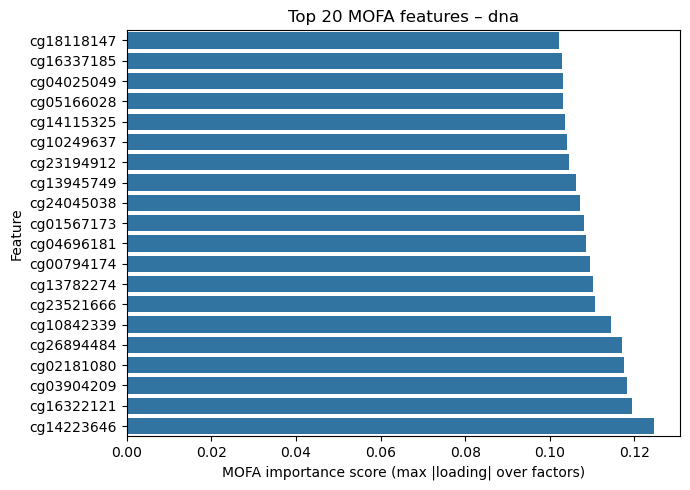


=== Top 20 features in modality 'rppa' ===


,feature,score
0,ERALPHA,0.402827
1,Gli1,0.341580
2,GATA3,0.258691
3,COLLAGENVI,0.252561
4,MAPK_pT202Y204,0.244137
5,CAVEOLIN1,0.241810
6,CYCLINB1,0.228697
7,MYH11,0.223104
8,HSP70,0.219382
9,INPP4B,0.208450


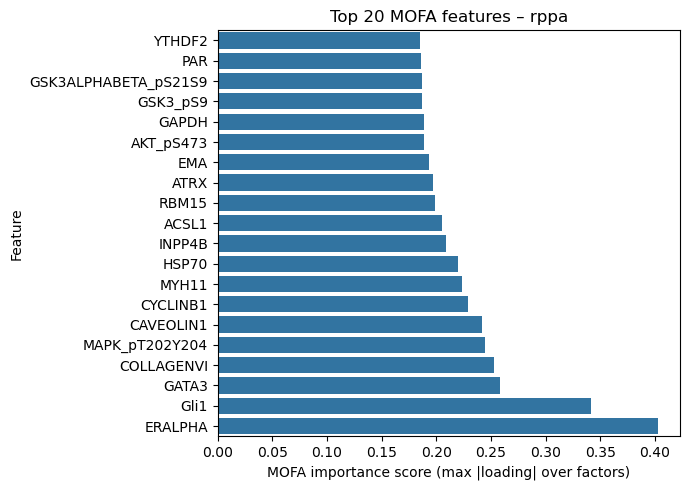

In [15]:
modalities = list(mdata_var_all.mod.keys())  
print("Modalities:", modalities)

top_per_view = {}

for mod in modalities:
    print(f"\n=== Top 20 features in modality '{mod}' ===")
    df_top = top_mofa_features_per_view(
        model=model_var_all,
        mdata=mdata_var_all,
        modality=mod,
        top_n=20,
        agg="max",
    )
    top_per_view[mod] = df_top
    display(df_top) 

    df_plot = df_top.sort_values("score", ascending=True)

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=df_plot,
        x="score",
        y="feature",
        ax=ax,
        color="tab:blue",
    )
    ax.set_xlabel("MOFA importance score (max |loading| over factors)")
    ax.set_ylabel("Feature")
    ax.set_title(f"Top 20 MOFA features – {mod}")

    fig.tight_layout()
    fig.savefig(f"top20_mofa_features_{mod}.pdf", dpi=300, bbox_inches="tight")
    plt.show()


#### Only on Factor X

In [50]:
import mygene
mg = mygene.MyGeneInfo()

def ensembl_to_symbol(ensembl_series: pd.Series) -> pd.Series:
    """
    Convert Ensembl gene IDs (with or without version) to symbols.
    If no symbol is found, keep the original ID.
    """
    base_ids = ensembl_series.astype(str).str.split(".").str[0]

    hits = mg.querymany(
        base_ids.tolist(),
        scopes="ensembl.gene",
        fields="symbol",
        species="human",
        as_dataframe=True,
    )

    mapping = {}
    for ensg, row in hits.iterrows():
        sym = row.get("symbol")
        mapping[ensg] = sym if isinstance(sym, str) else ensg

    return base_ids.map(mapping)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


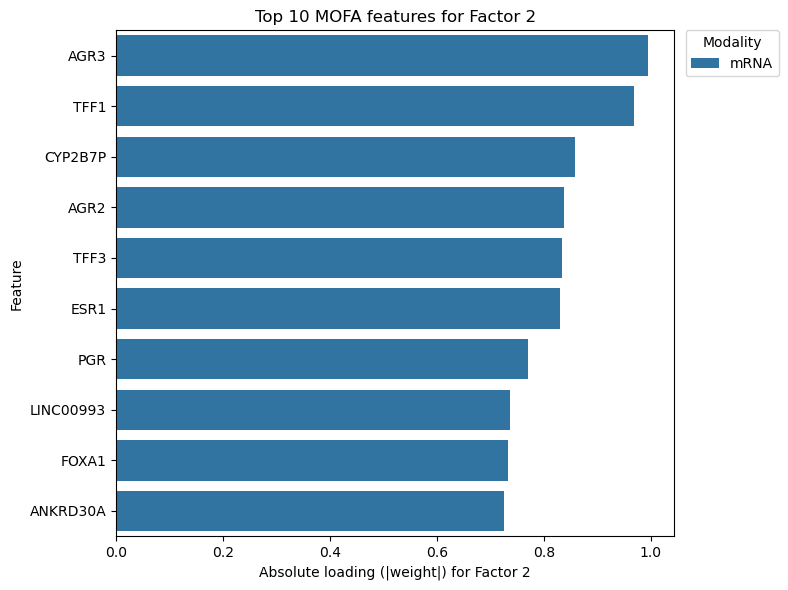

In [63]:
# top 10 features for factor 2 across all omics
top_f2 = top_mofa_features_factor(model_var_all, mdata_var_all, factor=1, top_n=10)
df = top_f2.copy()
df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

# Map Ensembl -> symbol (you already have this function)
df_sorted["symbol"] = ensembl_to_symbol(df_sorted["feature"])

# Nice labels for modalities
mod_map = {
    "rna": "mRNA",
    "dna": "DNAm",
    "rppa": "RPPA",
}
df_sorted["modality_pretty"] = (
    df_sorted["modality"].str.lower().map(mod_map).fillna(df_sorted["modality"])
)

# Fixed colors per omic
palette = {
    "mRNA": "#1f77b4",   # blue
    "DNAm": "#2ca02c",   # green
    "RPPA": "#ff7f0e",   # orange
}

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_sorted,
    x="score",
    y="symbol",
    hue="modality_pretty",
    dodge=False,
    palette=palette,
    ax=ax,
)

ax.set_xlabel("Absolute loading (|weight|) for Factor 2")
ax.set_ylabel("Feature")
ax.set_title("Top 10 MOFA features for Factor 2")

# Legend: mRNA / DNAm / RPPA on the right
ax.legend(
    title="Modality",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
)

fig.tight_layout()
fig.savefig("top_f2_symbols.pdf", dpi=300, bbox_inches="tight")
plt.show()


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
10 input query terms found no hit:	['Gli1', 'COLLAGENVI', 'CAVEOLIN1', 'MYH11', 'HSP70', 'RBM15', 'ATRX', 'EMA', 'GAPDH', 'YTHDF2']


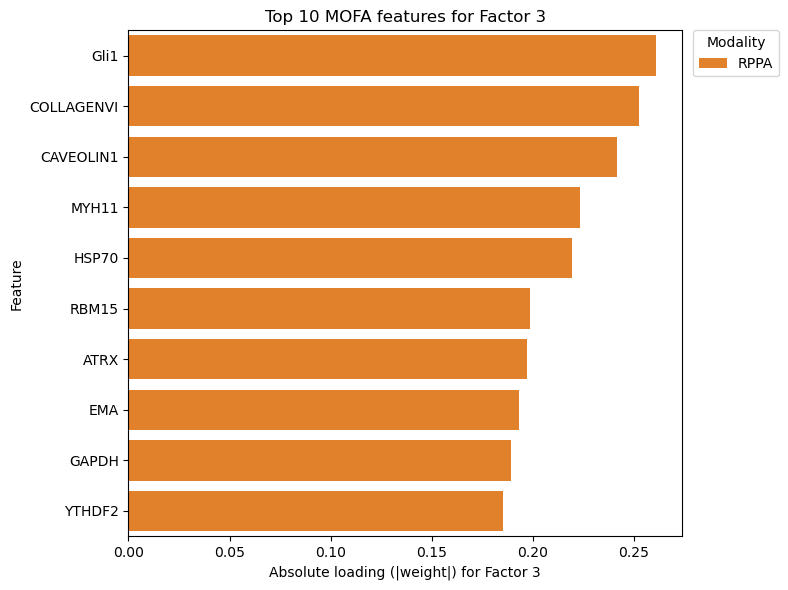

In [68]:
# top 10 features for factor 2 across all omics
top_f3 = top_mofa_features_factor(model_var_all, mdata_var_all, factor=2, top_n=10)
df = top_f3.copy()
df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

# Map Ensembl -> symbol (you already have this function)
df_sorted["symbol"] = ensembl_to_symbol(df_sorted["feature"])

# Nice labels for modalities
mod_map = {
    "rna": "mRNA",
    "dna": "DNAm",
    "rppa": "RPPA",
}
df_sorted["modality_pretty"] = (
    df_sorted["modality"].str.lower().map(mod_map).fillna(df_sorted["modality"])
)

# Fixed colors per omic
palette = {
    "mRNA": "#1f77b4",   # blue
    "DNAm": "#2ca02c",   # green
    "RPPA": "#ff7f0e",   # orange
}

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_sorted,
    x="score",
    y="symbol",
    hue="modality_pretty",
    dodge=False,
    palette=palette,
    ax=ax,
)

ax.set_xlabel("Absolute loading (|weight|) for Factor 3")
ax.set_ylabel("Feature")
ax.set_title("Top 10 MOFA features for Factor 3")

# Legend: mRNA / DNAm / RPPA on the right
ax.legend(
    title="Modality",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
)

fig.tight_layout()
fig.savefig("top_f3_symbols.pdf", dpi=300, bbox_inches="tight")
plt.show()


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


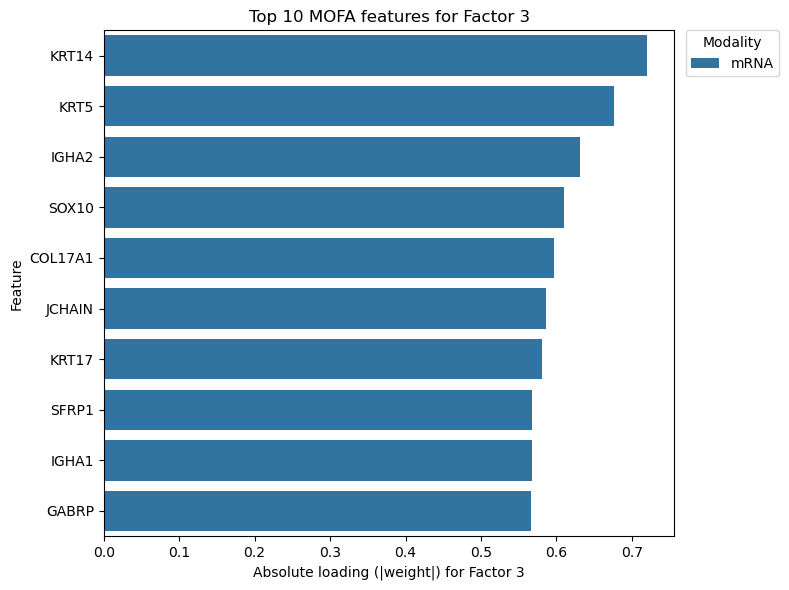

In [69]:
# top 10 features for factor 2 across all omics
top_f3 = top_mofa_features_factor(model_var_all, mdata_var_all, factor=3, top_n=10)
df = top_f3.copy()
df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

# Map Ensembl -> symbol (you already have this function)
df_sorted["symbol"] = ensembl_to_symbol(df_sorted["feature"])

# Nice labels for modalities
mod_map = {
    "rna": "mRNA",
    "dna": "DNAm",
    "rppa": "RPPA",
}
df_sorted["modality_pretty"] = (
    df_sorted["modality"].str.lower().map(mod_map).fillna(df_sorted["modality"])
)

# Fixed colors per omic
palette = {
    "mRNA": "#1f77b4",   # blue
    "DNAm": "#2ca02c",   # green
    "RPPA": "#ff7f0e",   # orange
}

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_sorted,
    x="score",
    y="symbol",
    hue="modality_pretty",
    dodge=False,
    palette=palette,
    ax=ax,
)

ax.set_xlabel("Absolute loading (|weight|) for Factor 3")
ax.set_ylabel("Feature")
ax.set_title("Top 10 MOFA features for Factor 3")

# Legend: mRNA / DNAm / RPPA on the right
ax.legend(
    title="Modality",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
)

fig.tight_layout()
fig.savefig("top_f3_symbols.pdf", dpi=300, bbox_inches="tight")
plt.show()


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


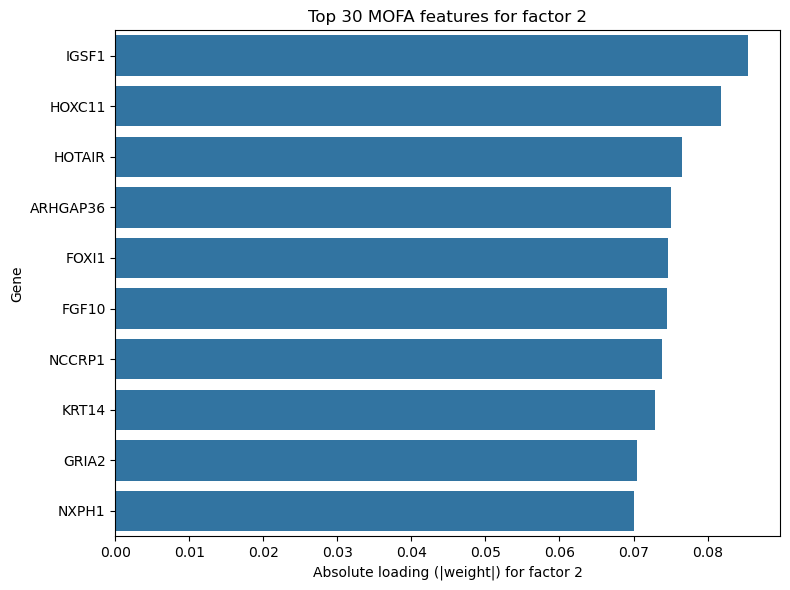

In [70]:
# top 10 features for factor 2 across all omics

top_f1 = top_mofa_features_factor(model_var_all, mdata_var_all, factor=0, top_n=10)
df = top_f1.copy()
df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

df_sorted["symbol"] = ensembl_to_symbol(df_sorted["feature"])

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_sorted,
    x="score",
    y="symbol",          # ← only ATF4, etc. here
    hue="modality",
    dodge=False,
    ax=ax,
)

ax.set_xlabel("Absolute loading (|weight|) for factor 2")
ax.set_ylabel("Gene")
ax.set_title("Top 30 MOFA features for factor 2")

#ax.legend(title="Modality", bbox_to_anchor=(1.02, 1), loc="upper left")
if ax.get_legend() is not None:
    ax.get_legend().remove()
fig.tight_layout()
fig.savefig("top_f2_symbols.pdf", dpi=300, bbox_inches="tight")
plt.show()
